In [1]:
from os import listdir
import cv2
import numpy as np
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16
from keras.layers import Input, Flatten, Dense, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import random
import os
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from keras.models import  load_model

In [2]:
X=[]
y=[]
width,height=128,128

#Đường dẫn folder
data_folder = "custom_dataset"

In [3]:
for folder in os.listdir(data_folder):
    curr_path = os.path.join(data_folder, folder)
    for file in os.listdir(curr_path):
        curr_file = os.path.join(curr_path, file)
        images = cv2.imread(curr_file)
        new_images = cv2.resize(images,(width,height))
        X.append(new_images)
        y.append(folder)
    
# Tiền xử lý dữ liệu
X = np.array(X)
y = np.array(y)

In [18]:
y

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]])

In [6]:
print(X.shape)

# Chuyển Label sang dạng nhị phân one hot
encoder = LabelBinarizer()
y=encoder.fit_transform(y)

#Label tương ứng với Class

for (i,lab) in enumerate(encoder.classes_):
    print("{}.{}".format(i+1,lab))
    
# Không biết lý do sao đọc folder ngược đời nên em phải làm vậy cho khỏi nhầm
class_names = ['10K', '100K', '20K','200K','50K']

# CHia dữ liệu thành các tập x,y train test
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)


(221, 128, 128, 3)
1.10
2.100
3.20
4.200
5.50


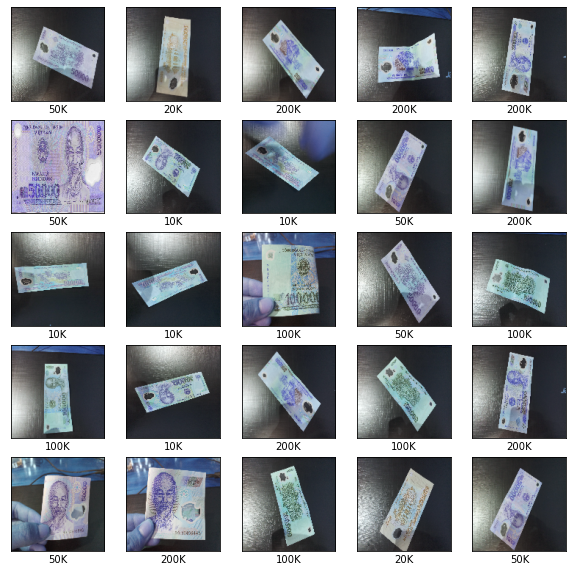

In [9]:
#Vẽ mấy cái ảnh xem thử
labels = np.array([int(np.where(x==1)[0]) for x in y_train])
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i],cmap=plt.cm.binary)
    plt.xlabel(class_names[labels[i]])
plt.show()

In [10]:
# Định nghĩa model (layer.trainable chặn FC của mạng VGG16)
# Khi đó khai báo 1 đoạn FC khác với đầu ra hàm softmax trong vecto lấy cái cao nhất
base_model = VGG16(input_shape=(128,128,3),weights='imagenet', include_top=False)

    # Dong bang cac layer
for layer in base_model.layers:
        layer.trainable = False


    # Them cac layer FC va Dropout
x = Flatten(name='flatten')(base_model.output)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dropout(0.5)(x)
x = Dense(5, activation='softmax', name='predictions')(x)

In [11]:
   # Compile
my_model = Model(base_model.input, x)
my_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    

# Dữ dụng data augument lúc train (Không cần làm lúc trc train)
# (phóng to,dịch sang trái,phải 1/10 độ rộng của ảnh,điều chỉnh độ sáng từ 0.2 đến 1.5,méo ảnh )
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.1,
    rescale=1./255,
 	width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=45,
 	horizontal_flip=True,
    brightness_range=[0.2,1.5],
    fill_mode="nearest")

aug_val = ImageDataGenerator(rescale=1./255)


In [12]:
aug_val

In [16]:
# Lưu kết quả train tốt hơn sau mỗi lần epochs lưu weight tốt nhất
filepath="best_weight/weights-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Fit thôi.. cái này sinh data khi train
my_model.fit_generator(aug.flow(X_train, y_train, batch_size=64),
                                epochs=1,# steps_per_epoch=len(X_train)//64,
                                validation_data=aug.flow(X_test,y_test,
                                batch_size=len(X_test)),
                                callbacks=callbacks_list)

my_model.save("models/model_SV1.h5")

3/3 [==============================] - ETA: 0s - loss: 0.6082 - accuracy: 0.7557
Epoch 00001: val_accuracy improved from -inf to 0.73333, saving model to best_weight\weights-01-0.73.hdf5
3/3 [==============================] - 7s 2s/step - loss: 0.6082 - accuracy: 0.7557 - val_loss: 0.9135 - val_accuracy: 0.7333


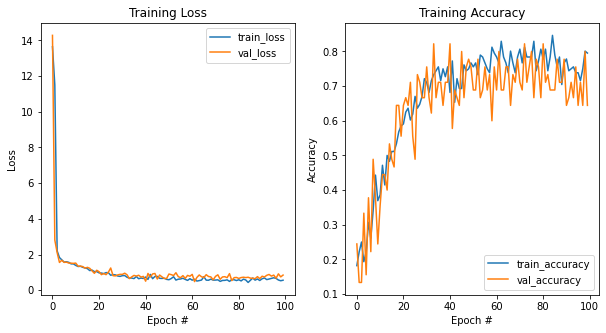

In [14]:
# hiển thị table trực quan
loss_data = my_model.history.history['loss']
accuracy_data = my_model.history.history['accuracy']
loss_val = my_model.history.history['val_loss']
accuracy_val = my_model.history.history['val_accuracy']

epoch_data =  my_model.history.epoch

f = plt.figure(figsize=(10,5))
ch1 = f.add_subplot(121)
ch2 = f.add_subplot(122)
ch1.plot(epoch_data, loss_data, label="train_loss")
ch1.plot(epoch_data, loss_val, label="val_loss")

ch1.set_title("Training Loss")
ch1.set_xlabel("Epoch #")
ch1.set_ylabel("Loss")
ch1.legend()
ch2.plot(epoch_data, accuracy_data, label="train_accuracy")
ch2.plot(epoch_data, accuracy_val, label="val_accuracy")
ch2.set_title("Training Accuracy")
ch2.set_xlabel("Epoch #")
ch2.set_ylabel("Accuracy")
ch2.legend()
plt.show()

In [15]:
# Đánh giá thử nghiệm 
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('Test accuracy:', test_acc)
print('Test Lost:', test_loss)

predictions = model.predict(X_test)

NameError: name 'model' is not defined